<a href="https://colab.research.google.com/github/shaahrzad91/-Intersection-of-Two-Linked-Lists/blob/master/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools


def load_datasets(dataset_path):
    image_transforms = [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    train_transforms = transforms.Compose(image_transforms)
    test_transforms = transforms.Compose(image_transforms[1:])  # skip augmentations

    train_dataset = datasets.ImageFolder(
        os.path.join(dataset_path, "train"), transform=train_transforms
    )
    val_dataset = datasets.ImageFolder(
        os.path.join(dataset_path, "val"), transform=train_transforms
    )
    test_dataset = datasets.ImageFolder(
        os.path.join(dataset_path, "test"), transform=test_transforms
    )

    return train_dataset, val_dataset, test_dataset


In [10]:
class ConvBNReLU_block(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


# Squeeze-and-Excitation Networks
# https://arxiv.org/abs/1709.01507
class SE_block(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)

    def forward(self, x):
        bs = x.size(0)
        out = self.avg_pool(x).view(bs, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        out = out.view(bs, -1, 1, 1)
        return x * out


class MaskNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mods = nn.Sequential(
            ConvBNReLU_block(3, 128, 3, stride=1, padding=1, dilation=1, bias=True),
            ConvBNReLU_block(128, 128, 3, stride=1, padding=1, dilation=1, bias=True),
            SE_block(128),
            ConvBNReLU_block(128, 128, 3, stride=2, padding=1, dilation=1, bias=True),
            ConvBNReLU_block(128, 64, 3, stride=1, padding=1, dilation=2, bias=True),
            SE_block(64),
            ConvBNReLU_block(64, 64, 3, stride=1, padding=1, dilation=1, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64, 3),
        )

    def forward(self, x):
        return self.mods(x)
    

108
Predicted:  Faces without Masks Faces with Masks Faces without Masks Faces with Masks
Accuracy of the network on the test images: 97 %
                     precision    recall  f1-score   support

   Faces with Masks       0.98      0.96      0.97       216
Faces without Masks       0.99      1.00      0.99       216
       Not a Person       0.97      0.98      0.97       216

           accuracy                           0.98       648
          macro avg       0.98      0.98      0.98       648
       weighted avg       0.98      0.98      0.98       648

Confusion matrix :
[[207   3   6]
 [  0 215   1]
 [  5   0 211]]


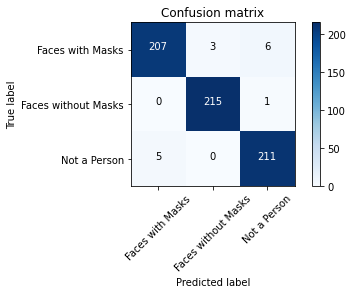

In [30]:

device = "cpu" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    r'/content/drive/MyDrive/comp6721_project1-main/checkpoints/lr1e-5/masknet-epoch=37-val_loss=0.04.ckpt',
    map_location=device,
)


state_dict = checkpoint["state_dict"]
state_dict = {k.partition("_model.")[2]: v for k, v in state_dict.items()}

model = MaskNet()
model.load_state_dict(state_dict)
model.eval();

train_dataset, val_dataset, test_dataset= load_datasets(r'/content/drive/MyDrive/comp6721_project1-main/dataset')
testloader = DataLoader( test_dataset , batch_size= 6, shuffle=True)
print(len(testloader))


dataiter= iter(testloader)
images, labels= dataiter.next()
outputs = model(images)
_, predicted = torch.max(model(images), 1)

print('Predicted: ', ' '.join('%5s' % test_dataset.classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
prediction_labels = []
true_labels = []
for data in testloader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    true_labels += labels.numpy().tolist()
    prediction_labels += predicted.numpy().tolist()



print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
Y_test = np.array(true_labels)
y_score = np.array(prediction_labels)
target_names = ['Faces with Masks', 'Faces without Masks', 'Not a Person']
print(classification_report(Y_test, y_score, target_names=target_names))
  
#Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_score)
print("Confusion matrix :")
print(cnf_matrix)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Faces with Masks', 'Faces without Masks', 'Not a Person'],normalize= False,  title='Confusion matrix')




